# Chlorophyll A Data Vis Workbook
### Amy Phung, March 2020

## Setup, Imports, & Globals

### Setup

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from jupyterthemes import jtplot
jtplot.style(theme="monokai", context="notebook", ticks=True, grid=False)

# pd.set_option('display.max_rows', 60)
# pd.set_option('display.max_columns', 30)
# pd.set_option('display.width', None)
# pd.set_option('display.max_colwidth', None)

### Imports

In [95]:
%matplotlib inline
import scipy
import glob
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import netCDF4
import itertools
from datetime import datetime

### Globals

In [56]:
STD_COLUMN_NAMES = ["Src", "Lat", "Long", "Chl-A", "Timestamp", 
                    "Station"]
SAT_COLUMN_NAMES = ["Filename", "Sat Lat", "Sat Long", "Sat Chl-A",
                   "Lat Error", "Long Error", "Time Error"]

## Helper Classes

In [125]:
# Best fit line
class BestFitLine:
    def __init__(self, x, y):
        self.slope, self.intercept, self.r_value, self.p_value, \
            self.std_err = scipy.stats.linregress(x, y)
    
    def computeY(self, x):
        return self.intercept + self.slope*x

## Data Classes

### Main Class

In [126]:
class Dataset:
    """
    Class for datasets with methods to process and reformat raw data
    
    Attributes:
        _source (str): String representing where data came from
        _cols (dict): Dictionary containing lookup for raw column names
        _raw_df (DataFrame): Pandas dataframe containing raw csv data
        df (DataFrame): Pandas dataframe containing formatted data
    """
    def __init__(self, filename, source, column_names):
        self._filename = filename
        self._source = source
        self._cols = column_names
        
    def _loadRaw(self):
        return pd.read_csv(self._filename)
        
    def _processRaw(self):
        pass
    
    def _parseDate(self):
        """ Convert an unformatted timestamp in raw dataset to a Python 
        datetime then to a timestamp. Returns timestamp """
        pass
    
    def _formatData(self):
        self.df["Src"] = self._source
        self.df["Lat"] = self._raw_df[self._cols["Lat"]]
        self.df["Long"] = self._raw_df[self._cols["Long"]]
        self.df["Chl-A"] = self._raw_df[self._cols["Chl-A"]]
        self.df["Timestamp"] = self._raw_df.apply(self._parseDate, axis=1)
        self.df["Station"] = self._raw_df[self._cols["Station"]]

### BGC Class

In [127]:
class DatasetBGC(Dataset):
    def __init__(self, filename, source, column_names):
        Dataset.__init__(self, filename, source, column_names)
        self._raw_df = self._loadRaw()
        self._processRaw()
        self.df = pd.DataFrame(index=range(0,len(self._raw_df)),
                               columns=STD_COLUMN_NAMES)
        self._formatData()
        
    def _processRaw(self):
        # Remove unused columns
        self._raw_df.dropna(axis=1, how='all', inplace=True) 
        # Drop points missing chlorophyll values
        self._raw_df.dropna(inplace=True) 
        # Drop duplicates (for some reason stations 1-9 like to duplicate)
        self._raw_df.drop_duplicates(inplace=True) 
        # Add in column with station numbers
        self._raw_df["Station Num"] = range(1, len(self._raw_df)+1) 
        # Normalize chlorophyll data
        self._raw_df[self._cols["Chl-A"]] = \
            self._raw_df[self._cols["Chl-A"]]/20. 
        self._raw_df.reset_index(inplace=True)
        
    def _parseDate(self, df_row):
        time_str = df_row["yyyy-mm-ddThh:mm:ss.sss"]
        year   = int(time_str[0:4])
        month  = int(time_str[5:7])
        day    = int(time_str[8:10])
        hour   = int(time_str[11:13])
        minute = int(time_str[14:16])
        second = int(time_str[17:19])
        
        date = datetime(year, month, day, hour, minute, second)
        timestamp = datetime.timestamp(date)
        return timestamp

### HC Class

In [197]:
class DatasetHC(Dataset):
    def __init__(self, filename, source, column_names):
        Dataset.__init__(self, filename, source, column_names)
        self._best_fit_line = None
        self._cal_df = None

        self._raw_df = self._loadRaw()
        self._processRaw()
        
        self.df = pd.DataFrame(index=range(0,len(self._raw_df)),
                               columns=STD_COLUMN_NAMES)
        self._formatData()
        
    def _loadRaw(self):
        # To get data from ODV:
        # Export>Station Data>ODV Spreadsheet file>Uncheck all exports
        return pd.read_csv(self._filename, delimiter="\t",header=27)
        
    def _processRaw(self):
        # Fill in cruise, station, type, date, lat, long, bottom depth 
        # with most recent values
        col_to_fill = ["Cruise", 
                       "Station",
                       "Type",
                       "yyyy-mm-ddThh:mm:ss.sss",
                       "Longitude [degrees_east]",
                       "Latitude [degrees_north]",
                       "Bot. Depth [m]"]
        
        for col in col_to_fill: self._raw_df[col].fillna(method="pad", 
                                                         inplace=True)
        # Add in column with station numbers as integers
        self._raw_df["Station Num"] = \
            self._raw_df["Station"].apply(self._getStationNum) 
        # Add in column with corrected timestamps
        self._raw_df["Corrected Timestamp"] = \
            self._raw_df["yyyy-mm-ddThh:mm:ss.sss"].apply(self._correctHCTimestamp)
        # Only keep points with valid Chl-A fluorescence measurements
        self._raw_df.dropna(subset=["Chl a Fluorescence [V]"], inplace=True)
        # Compute best fit line for calibrated Chl-A data
        self._best_fit_line, self._cal_df = self._calibrateData()
        # Apply best fit line to full dataset
        self._raw_df["Calculated Chl-A"] = \
            self._raw_df["Chl a Fluorescence [V]"].apply( \
            self._best_fit_line.computeY)
    
    def _parseDate(self, df_row):
        time_str = df_row["Corrected Timestamp"]
        year   = int(time_str[0:4])
        month  = int(time_str[5:7])
        day    = int(time_str[8:10])
        hour   = int(time_str[11:13])
        minute = int(time_str[14:16])
        
        date = datetime(year, month, day, hour, minute)
        timestamp = datetime.timestamp(date)
        return timestamp
    
    # Other Functions
    def _getStationNum(self, station_name):
        """Parses station name from hydrocast dataset and returns an int 
        representing station number.

        Args:
            station_name (str): Hydrocast station name in the format S290-###-HC

        Returns:
            station_num (int): Hydrocast station number
        """
        return int(station_name[5:8])
    
    def _correctHCTimestamp(self, timestamp):
        """Applies correction to HC timestamp - 2020 is incorrectly written as
        0020, so this function returns a new timestamp in the correct format

        Args:
            timestamp (str): Incorrect timestamp from hydrocast data

        Returns:
            corrected_timestamp (str): Corrected timestamp
        """
        new_timestamp = "2020" + timestamp[4:]
        return new_timestamp
        
    def _calibrateData(self):
        # Create calibration dataset
        cal_df = self._raw_df.dropna(subset=["Chl-a [ug/L]"])

        hc_fit_line = BestFitLine(cal_df["Chl a Fluorescence [V]"],
                                  cal_df["Chl-a [ug/L]"])
        return hc_fit_line, cal_df
    
    # Visualizations
    def visualizeCalibration(self):
        plt.scatter(self._cal_df["Chl a Fluorescence [V]"], 
                    self._cal_df["Chl-a [ug/L]"], 
                    c=self._cal_df["Depth [m]"],
                    marker='.')
        plt.colorbar()
        plt.xlabel("Chl a Fluorescence [V]")
        plt.ylabel("Chl-a [ug/L]")
        plt.title("Hydrocast Chl-A Best Fit Calibration Line")

        xp = np.linspace(self._cal_df["Chl a Fluorescence [V]"].min(),
                         self._cal_df["Chl a Fluorescence [V]"].max(),
                         100)
        plt.plot(xp, self._best_fit_line.computeY(xp))

        

1.0545750053408705e-10


,Src,Lat,Long,Chl-A,Timestamp,Station
0,HC,-36.357,175.172,0.141415,1.582019e+09,1.0
1,HC,-36.357,175.172,0.143940,1.582019e+09,1.0
2,HC,-36.357,175.172,0.148569,1.582019e+09,1.0
3,HC,-36.357,175.172,0.146044,1.582019e+09,1.0
4,HC,-36.357,175.172,0.146044,1.582019e+09,1.0
...,...,...,...,...,...,...
11262,HC,-38.841,179.840,0.095918,1.583772e+09,26.0
11263,HC,-39.494,178.774,0.201128,1.583815e+09,27.0
11264,HC,-39.494,178.774,0.213762,1.583815e+09,27.0
11265,HC,-39.494,178.774,0.537931,1.583815e+09,27.0


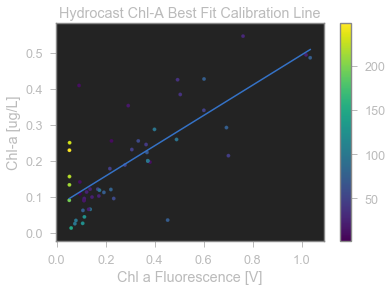

In [199]:
hc_cols = {"Lat": "Latitude [degrees_north]",
           "Long": "Longitude [degrees_east]",
           "Chl-A": "Calculated Chl-A",
           "Station": "Station Num"}
hc_data = DatasetHC("data/data_from_S290-CTD-HC-2.txt", "HC", hc_cols)
print(hc_data._best_fit_line.p_value)
hc_data.visualizeCalibration()
hc_data.df

## Main Script

In [181]:
bgc_cols = {"Lat": "Latitude [degrees_north]",
            "Long": "Longitude [degrees_east]",
            "Chl-A": "Integral_0 { Chlorophyll-A (original) } * d_Pressure (original) [mg m~^-~^3 * decibar] @ Pressure (original) [decibar]=20.0",
            "Station": "Station Num"}
bgc_data = DatasetBGC("data/argo-isosurface-data.csv", "BGC", bgc_cols)
bgc_data.df

,Src,Lat,Long,Chl-A,Timestamp,Station
0,BGC,-32.465,185.24200,0.598395,1.501384e+09,1
1,BGC,-32.267,185.30000,0.628195,1.502250e+09,2
2,BGC,-32.298,185.25600,0.415292,1.503110e+09,3
3,BGC,-32.560,185.32600,0.514820,1.503982e+09,4
4,BGC,-32.979,185.25101,0.363909,1.504851e+09,5
...,...,...,...,...,...,...
88,BGC,-42.033,185.93600,0.321619,1.577313e+09,89
89,BGC,-41.869,186.26900,0.333278,1.578173e+09,90
90,BGC,-41.677,186.60600,0.228063,1.579034e+09,91
91,BGC,-41.507,186.82600,0.214175,1.579899e+09,92
